In [1]:
%%writefile file.py

import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.distributed as dist
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from datetime import datetime
import os
import torch.multiprocessing as mp
import time
import warnings
warnings.filterwarnings("ignore")


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('-n', '--nodes', default=1, type=int, metavar='N')
    parser.add_argument('-g', '--gpus', default=1, type=int,
                        help='number of gpus per node')
    parser.add_argument('-nr', '--nr', default=0, type=int,
                        help='ranking within the nodes')
    parser.add_argument('--epochs', default=2, type=int, metavar='N',
                        help='number of total epochs to run')
    args = parser.parse_args()

    args.world_size = args.gpus * args.nodes
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '5555'
    mp.spawn(train, nprocs=args.gpus, args=(args,))

    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x
    
def train(gpu, args):
    rank = args.nr * args.gpus + gpu
    dist.init_process_group(
    	backend='nccl',
   		init_method='env://',
    	world_size=args.world_size,
    	rank=rank
    )

    torch.manual_seed(0)
    model = Net()
    torch.cuda.set_device(gpu)
    model.cuda(gpu)
    batch_size = 2048
    criterion = nn.CrossEntropyLoss().cuda(gpu)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    model = nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

    train_dataset = torchvision.datasets.MNIST(root='./',
                                               train=True,
                                               transform=transforms.ToTensor(),
                                               download=True)
    
    train_sampler = torch.utils.data.distributed.DistributedSampler(
    	train_dataset,
    	num_replicas=args.world_size,
    	rank=rank
    )
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=0,
                                               pin_memory=True,
                                               sampler=train_sampler)
    test_dataset = torchvision.datasets.MNIST(root='./',
                                              train=False, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=args.world_size,
        rank=rank
    )
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=100,
                                              shuffle=False,
                                              num_workers=0,
                                              pin_memory=True,
                                              sampler=test_sampler)

    # Variables for tracking training statistics
    acc_list2 = []
    loss_list2= []
    total_time = 0
    total_step = len(train_loader)

    for epoch in range(args.epochs):
        start_time = time.time()
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, GPU: {}'.format(
                    epoch + 1, 
                    args.epochs, 
                    i + 1, 
                    total_step,
                    loss.item(),
                    rank)
                    )
                
        end_time = time.time()
        total_time+=(end_time - start_time)
        loss_list2.append(loss.item())
                      
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        acc_list2.append(train_accuracy)

        print('Epoch: {}, Train Accuracy: {:.4f}, Time: {}, GPU: {}'
              .format(epoch, train_accuracy, end_time - start_time, rank))
        
    if gpu == 0:
        print("Total Time Taken: ",total_time)
    
        model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        print('Classification Report:\n', classification_report(all_labels, all_predictions))
        print('--------------------------------------------')
        print("CM: ", cm)  
        print('--------------------------------------------')
        print("Loss List: ", loss_list2)
        print("Acc List:  ", acc_list2)             
if __name__ == '__main__':
    main()

Writing file.py


In [3]:
!python file.py --nodes=1 --gpus=2 --nr=0 --epochs=30

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Epoch: 0, Train Accuracy: 0.1124, Time: 8.79268765449524, GPU: 1
Epoch: 0, Train Accuracy: 0.1124, Time: 8.84453821182251, GPU: 0
Epoch: 1, Train Accuracy: 0.4842, Time: 3.416536808013916, GPU: 1
Epoch: 1, Train Accuracy: 0.4831, Time: 3.506432056427

In [5]:
loss_list2 = [1.0481328964233398, 0.7052494883537292, 0.4818871319293976, 0.36508527398109436, 0.28440800309181213, 0.2222217470407486, 0.19684703648090363, 0.1734277606010437, 0.15694542229175568, 0.1263798475265503, 0.11888567358255386, 0.10716938227415085, 0.11139609664678574, 0.08049295097589493, 0.0938161164522171, 0.09115836024284363, 0.08253888785839081, 0.06926021724939346, 0.06514410674571991, 0.06378404796123505, 0.05550500750541687, 0.061975523829460144, 0.05382492393255234, 0.0474812388420105, 0.05769159272313118, 0.04794953390955925, 0.043257132172584534, 0.03309280052781105, 0.04366467148065567, 0.035031307488679886]
acc_list2 = [0.11236666666666667, 0.4831, 0.9473, 0.9789, 0.9861666666666666, 0.9894333333333334, 0.9907, 0.9919333333333333, 0.9925333333333334, 0.9935333333333334, 0.9941, 0.9945333333333334, 0.9951666666666666, 0.9956333333333334, 0.9956666666666667, 0.9953, 0.9964, 0.9962333333333333, 0.9974666666666666, 0.9979666666666667, 0.9977666666666667, 0.9973333333333333, 0.9980333333333333, 0.9984333333333333, 0.9983333333333333, 0.9985333333333334, 0.9985333333333334, 0.9989333333333333, 0.9984666666666666, 0.9989333333333333]
cm= [[508,0,   1,   0,   0,   0,   0,   0,   0,   0],
 [  0 ,571,   0 ,  0,   0,   0,   0,   0,   0,   0],
 [  0  , 0, 512,   0,   0,   0,   0,   0,   0,   0],
 [  0 ,  0 ,  0 ,530,   0,   2,   0,   0,   1,   0],
 [  0  , 0  , 0 ,  0, 495,   0,   1,   0,   1,   8],
 [  0 ,  0   ,0 ,  1,   0, 440,   0,   0,   0,   0],
 [  2,   1   ,0,   0,   0,   0, 475,   0,   2,   0],
 [  0,   2,   2,   1,   0,   0,   0, 498,   0,   1],
 [  1,   0,   1,   1,   0,   0,   0,   0, 459,   0],
 [  0,   0,   0,   0,   2,   3,   0,   1,   1, 476]]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


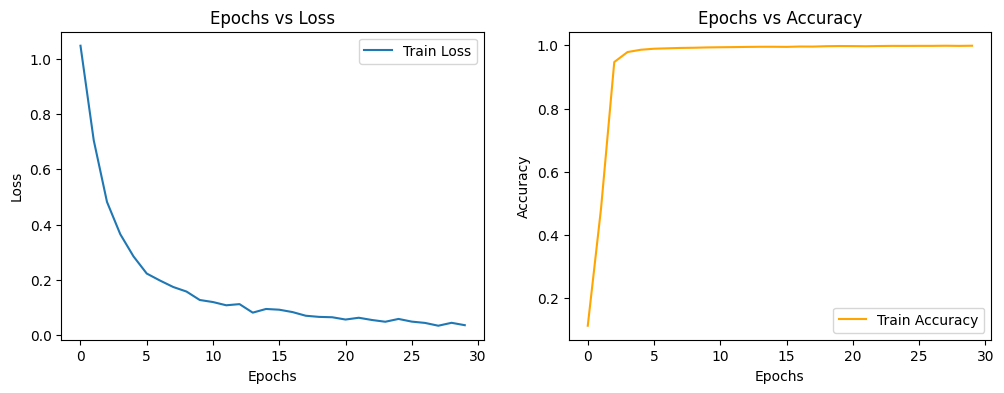

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list2, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list2, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

<Axes: >

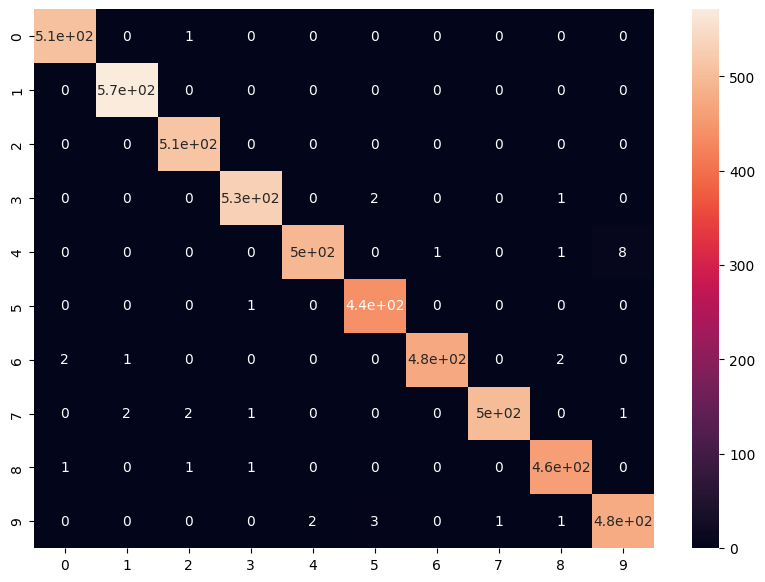

In [9]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [10]:
acc_list1 = [0.9029,
 0.9789,
 0.9856,
 0.9883,
 0.9893,
 0.9913,
 0.9909,
 0.9917,
 0.9928,
 0.9931,
 0.9929,
 0.9938,
 0.9932,
 0.9939,
 0.9938,
 0.994,
 0.9938,
 0.995,
 0.9944,
 0.9939,
 0.9944,
 0.9943,
 0.9949,
 0.9944,
 0.994,
 0.9945,
 0.9941,
 0.9948,
 0.9941,
 0.9947]
loss_list1 = [0.8040516376495361,
 0.44032618403434753,
 0.2560282349586487,
 0.19499582052230835,
 0.13441415131092072,
 0.12629814445972443,
 0.08717360347509384,
 0.08091559261083603,
 0.08949543535709381,
 0.08196837455034256,
 0.07355967909097672,
 0.07764915376901627,
 0.04295846074819565,
 0.03800318390130997,
 0.05848802253603935,
 0.0856185257434845,
 0.048205044120550156,
 0.04154835268855095,
 0.03205433487892151,
 0.0268377885222435,
 0.05535236746072769,
 0.026635464280843735,
 0.025002503767609596,
 0.02280045486986637,
 0.041113123297691345,
 0.03704504668712616,
 0.0319054052233696,
 0.04000399634242058,
 0.04553082212805748,
 0.01603255607187748]

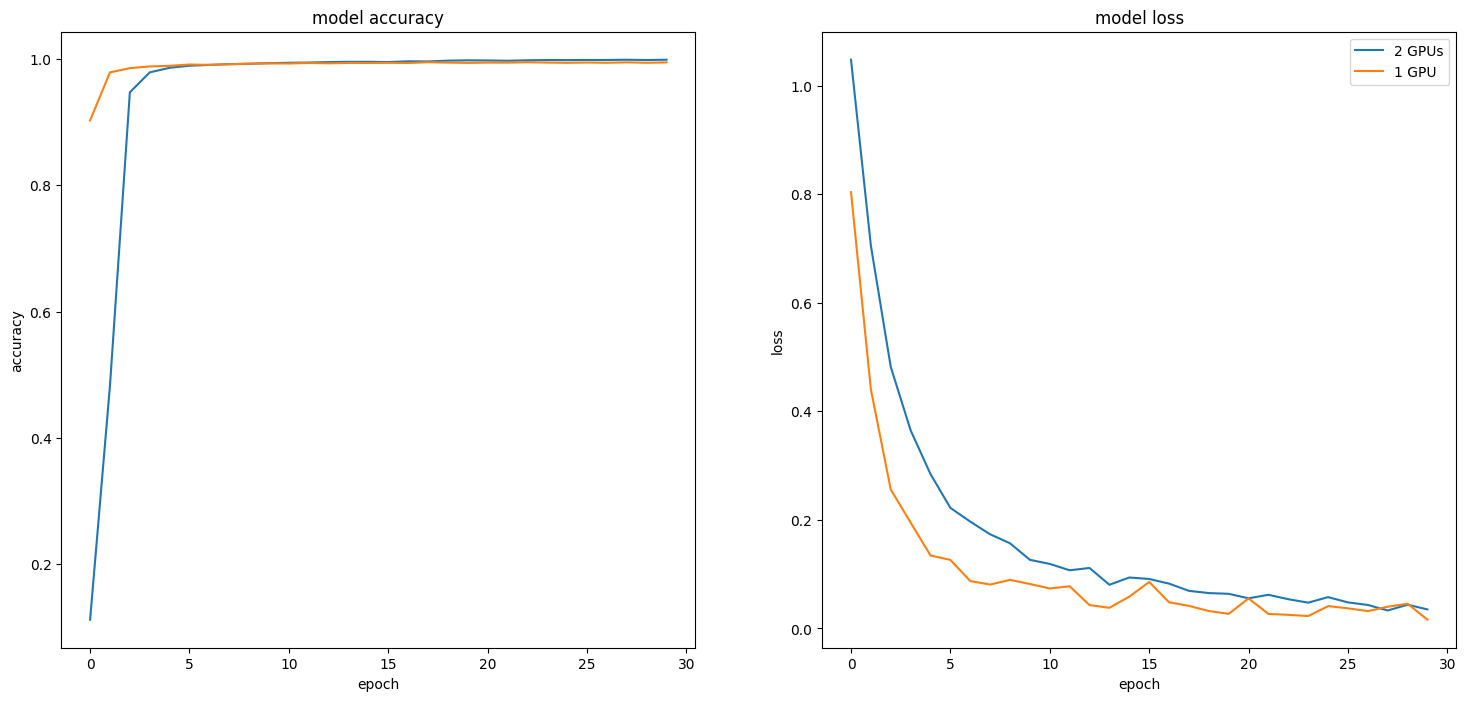

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(acc_list2,label = '2 GPUs')
axs[0].plot(acc_list1,label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(loss_list2,label = '2 GPUs')
axs[1].plot(loss_list1,label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

We achieve 184.88 percent of scaling


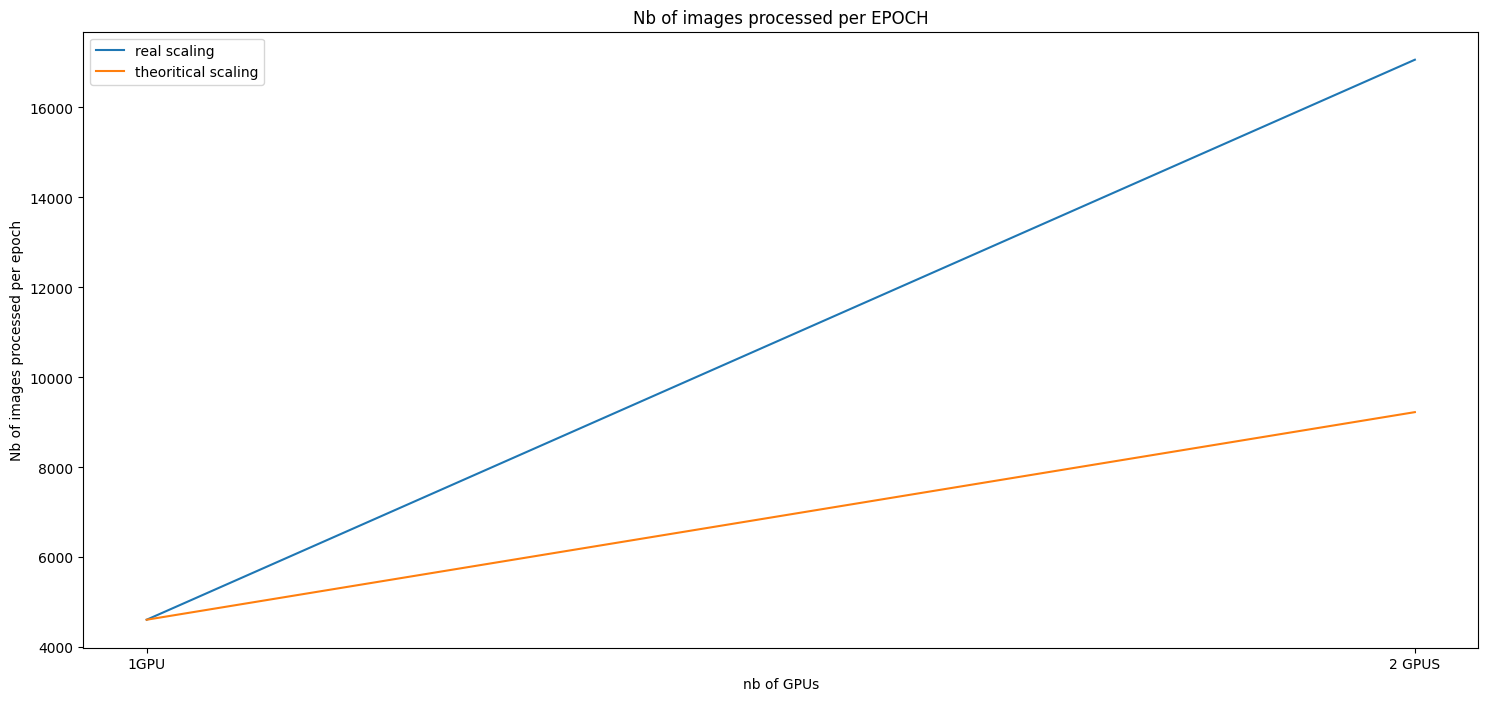

In [13]:
EPOCHS = 30
plt.figure(figsize=(18,8))
nb_images = 60000
plt.plot(['1GPU','2 GPUS'],[nb_images/(390.10/EPOCHS),nb_images/(105.50/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(390.10/EPOCHS),2*nb_images/(390.10/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((390.10/(2*105.50))*100,2))